# Task 3: Interpret the Embedding Space



In [5]:
# Ensure repo root is on sys.path for `utils` imports
from pathlib import Path
import sys
repo_root = Path.cwd().parent
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))
print('Added to sys.path:', repo_root)


Added to sys.path: /cs/student/projects1/aibh/2024/rmaheswa/Helical_Task/als-perturb-geneformer


In [6]:
import os
os.environ["PIP_CACHE_DIR"] = "/cs/student/projects1/aibh/2024/rmaheswa/cache"
os.environ["HF_HOME"] = "/cs/student/projects1/aibh/2024/rmaheswa/cache/huggingface"
os.environ["TRANSFORMERS_CACHE"] = "/cs/student/projects1/aibh/2024/rmaheswa/cache/transformers"

In [7]:
from pathlib import Path
import numpy as np
import pandas as pd

from utils.metrics import (
    centroid, delta_to_healthy, wasserstein1d_along_pc, knn_overlap_fraction,
    silhouette_scores_by_label, composite_score
)
from utils.plotting import umap_2d, plot_umap, plot_centroid_shifts

# Use absolute paths matching Task 2 outputs
EMB_DIR = Path('/cs/student/projects1/aibh/2024/rmaheswa/Helical_Task/als-perturb-geneformer/als-perturb-geneformer/data/embeddings')
FIG_DIR = Path('/cs/student/projects1/aibh/2024/rmaheswa/Helical_Task/als-perturb-geneformer/als-perturb-geneformer/data/figs')
FIG_DIR.mkdir(parents=True, exist_ok=True)

# Load embeddings saved in Task 2
healthy_path = EMB_DIR / 'healthy_base.npz'
als_path = EMB_DIR / 'als_base.npz'
if not (healthy_path.exists() and als_path.exists()):
    raise FileNotFoundError("Missing healthy_base.npz or als_base.npz. Run notebook 02 first.")

healthy = np.load(healthy_path)['arr']
als = np.load(als_path)['arr']

# Load perturbation embeddings (split by cohort)
healthy_up = {}
for p in sorted(EMB_DIR.glob('healthy_*_up.npz')):
    healthy_up[p.stem.replace('healthy_', '')] = np.load(p)['arr']
als_down = {}
for p in sorted(EMB_DIR.glob('als_*_down.npz')):
    als_down[p.stem.replace('als_', '')] = np.load(p)['arr']

# Metrics (compute separately for ALS→healthy shifts vs healthy→disease shifts)
rows = []
# ALS → rescue (down): compare ALS baseline vs healthy
for name, emb_als_pert in als_down.items():
    d_health = delta_to_healthy(als, emb_als_pert, healthy)  # negative = moved toward healthy
    w1d_before = wasserstein1d_along_pc(als, healthy)
    w1d_after = wasserstein1d_along_pc(emb_als_pert, healthy)
    knn_gain = knn_overlap_fraction(healthy, emb_als_pert, k=15) - knn_overlap_fraction(healthy, als, k=15)
    sil_before = silhouette_scores_by_label(np.vstack([healthy, als]), ['healthy']*len(healthy)+['als']*len(als))
    sil_after = silhouette_scores_by_label(np.vstack([healthy, emb_als_pert]), ['healthy']*len(healthy)+['als_pert']*len(emb_als_pert))
    rows.append({
        'set': 'ALS_down',
        'perturbation': name,
        'delta_to_healthy': d_health,
        'improvement_toward_healthy': -d_health,
        'wasserstein_before': w1d_before,
        'wasserstein_after': w1d_after,
        'knn_overlap_gain': knn_gain,
        'silhouette_before': sil_before,
        'silhouette_after': sil_after,
    })

# Healthy → disease-like (up): compare Healthy baseline vs Healthy
for name, emb_h_pert in healthy_up.items():
    d_from_healthy = delta_to_healthy(healthy, emb_h_pert, healthy)  # positive = moved away from healthy
    w1d_before = 0.0  # W(healthy, healthy) = 0
    w1d_after = wasserstein1d_along_pc(healthy, emb_h_pert)
    knn_gain = knn_overlap_fraction(healthy, emb_h_pert, k=15) - knn_overlap_fraction(healthy, healthy, k=15)
    sil_before = 0.0
    sil_after = silhouette_scores_by_label(np.vstack([healthy, emb_h_pert]), ['healthy']*len(healthy)+['healthy_pert']*len(emb_h_pert))
    rows.append({
        'set': 'Healthy_up',
        'perturbation': name,
        'delta_from_healthy': d_from_healthy,
        'wasserstein_before': w1d_before,
        'wasserstein_after': w1d_after,
        'knn_overlap_gain': knn_gain,
        'silhouette_before': sil_before,
        'silhouette_after': sil_after,
    })

metrics_df = pd.DataFrame(rows)
metrics_df.to_csv(FIG_DIR / 'task3_metrics.csv', index=False)

print("✓ Metrics computed and saved to:", FIG_DIR / 'task3_metrics.csv')


✓ Metrics computed and saved to: /cs/student/projects1/aibh/2024/rmaheswa/Helical_Task/als-perturb-geneformer/als-perturb-geneformer/data/figs/task3_metrics.csv


/cs/student/projects1/aibh/2024/rmaheswa/Helical_Task/.venv-gf310/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


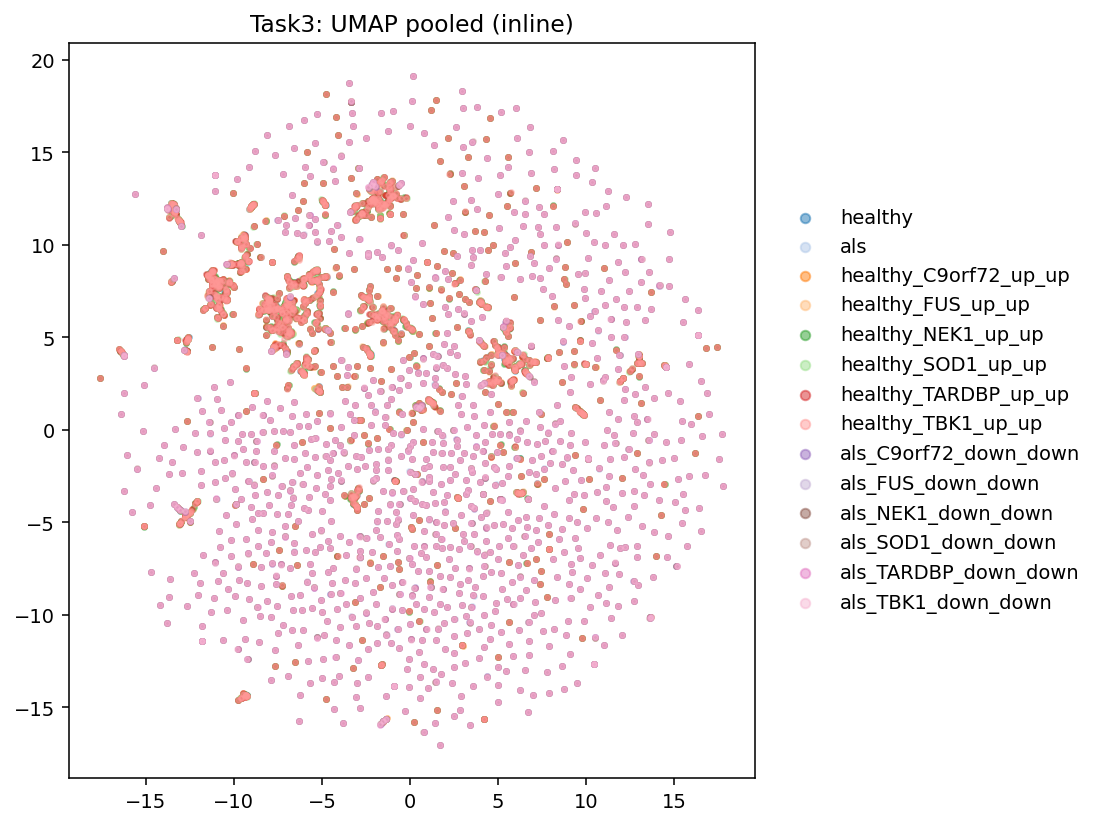

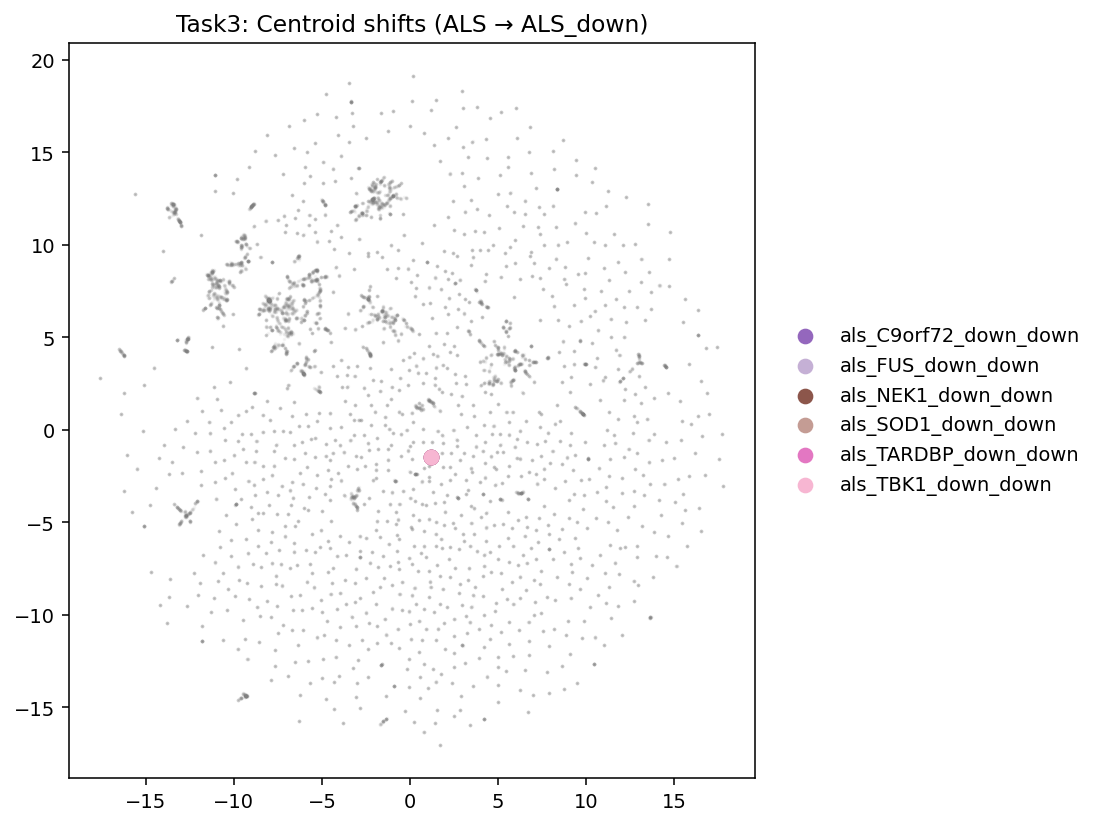

ALS_down (rescue) — best improvement toward healthy:


,perturbation,improvement_toward_healthy,delta_to_healthy,wasserstein_before,wasserstein_after,knn_overlap_gain,silhouette_before,silhouette_after
2,NEK1_down,0.0015,-0.0015,2.0892,2.0872,-0.0000,0.0746,0.0745
4,TARDBP_down,-0.0001,0.0001,2.0892,2.0896,0.0000,0.0746,0.0746
5,TBK1_down,-0.0001,0.0001,2.0892,2.0890,0.0000,0.0746,0.0746
0,C9orf72_down,-0.0002,0.0002,2.0892,2.0892,-0.0001,0.0746,0.0747
1,FUS_down,-0.0021,0.0021,2.0892,2.0938,0.0000,0.0746,0.0748
3,SOD1_down,-0.0062,0.0062,2.0892,2.0962,-0.0003,0.0746,0.0752



Healthy_up (disease-like) — farthest from healthy:


,perturbation,delta_from_healthy,wasserstein_after,knn_overlap_gain,silhouette_after
9,SOD1_up,0.0588,0.0274,-0.4072,0.0077
7,FUS_up,0.0363,0.0285,-0.2738,0.0032
8,NEK1_up,0.0344,0.0731,-0.3616,0.0059
11,TBK1_up,0.0230,0.0281,-0.1622,0.0010
6,C9orf72_up,0.0194,0.0232,-0.1660,0.0009
10,TARDBP_up,0.0151,0.0171,-0.0865,-0.0004


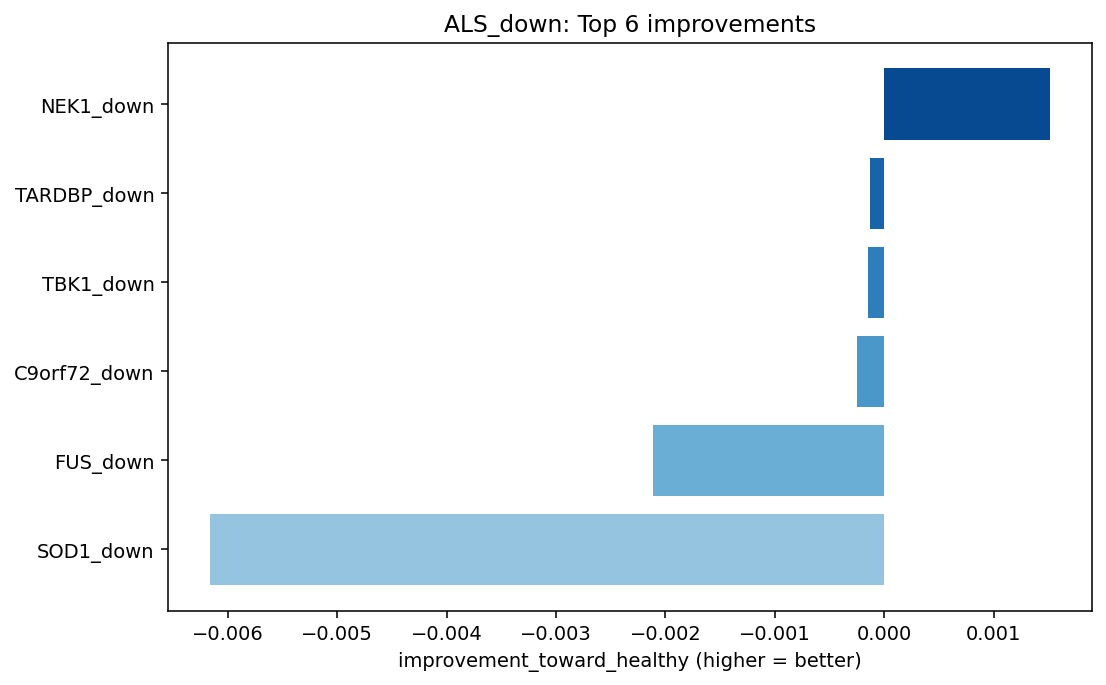

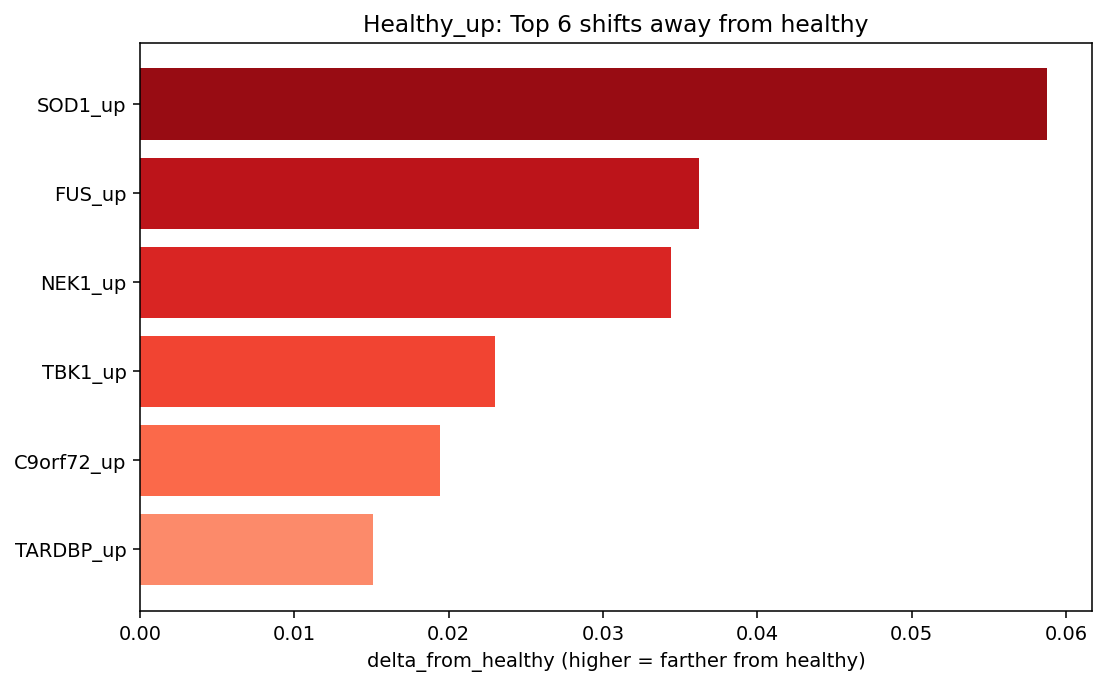

In [8]:
# Inline interpretation with healthy_up / als_down
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 1) UMAP pooled (recompute from already-loaded arrays)
pool = [healthy, als] + list(healthy_up.values()) + list(als_down.values())
labels = (['healthy'] * len(healthy) +
          ['als'] * len(als) +
          sum([[f'healthy_{k}_up'] * len(v) for k, v in healthy_up.items()], []) +
          sum([[f'als_{k}_down'] * len(v) for k, v in als_down.items()], []))
X = np.vstack(pool)
pts = umap_2d(X)

categories = (['healthy', 'als'] +
              [f'healthy_{k}_up' for k in sorted(healthy_up.keys())] +
              [f'als_{k}_down' for k in sorted(als_down.keys())])
palette = {c: plt.cm.tab20(i % 20) for i, c in enumerate(categories)}
label_arr = np.array(labels)

plt.figure(figsize=(8, 6), dpi=140)
for c in categories:
    m = (label_arr == c)
    if m.any():
        plt.scatter(pts[m, 0], pts[m, 1], s=6, alpha=0.5, c=[palette[c]], label=c)
plt.title('Task3: UMAP pooled (inline)')
plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=False, markerscale=2)
plt.tight_layout()
plt.show()

# 2) Centroid shifts (ALS baseline → ALS_down)
plt.figure(figsize=(8, 6), dpi=140)
plt.scatter(pts[:, 0], pts[:, 1], s=1, alpha=0.06, color='gray')
cent_als = pts[label_arr == 'als'].mean(axis=0)
for k in sorted(als_down.keys()):
    tag = f'als_{k}_down'
    m = (label_arr == tag)
    if m.any():
        c = pts[m].mean(axis=0)
        plt.scatter(c[0], c[1], s=50, c=[palette[tag]], label=tag)
plt.title('Task3: Centroid shifts (ALS → ALS_down)')
plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=False)
plt.tight_layout()
plt.show()

# 3) Metrics — show separate rankings for ALS_down and Healthy_up
als_df = metrics_df[metrics_df['set'] == 'ALS_down'].copy()
als_df = als_df.sort_values('improvement_toward_healthy', ascending=False)
healthy_df = metrics_df[metrics_df['set'] == 'Healthy_up'].copy()
healthy_df = healthy_df.sort_values('delta_from_healthy', ascending=False)

print('ALS_down (rescue) — best improvement toward healthy:')
display(als_df[['perturbation','improvement_toward_healthy','delta_to_healthy','wasserstein_before','wasserstein_after','knn_overlap_gain','silhouette_before','silhouette_after']]
       .style.format({'improvement_toward_healthy':'{:.4f}','delta_to_healthy':'{:.4f}','wasserstein_before':'{:.4f}','wasserstein_after':'{:.4f}','knn_overlap_gain':'{:.4f}','silhouette_before':'{:.4f}','silhouette_after':'{:.4f}'}))

print('\nHealthy_up (disease-like) — farthest from healthy:')
display(healthy_df[['perturbation','delta_from_healthy','wasserstein_after','knn_overlap_gain','silhouette_after']]
       .style.format({'delta_from_healthy':'{:.4f}','wasserstein_after':'{:.4f}','knn_overlap_gain':'{:.4f}','silhouette_after':'{:.4f}'}))

# Bar plots
top_k = 6
plt.figure(figsize=(8, 5), dpi=140)
subset = als_df.head(top_k)
plt.barh(subset['perturbation'][::-1], subset['improvement_toward_healthy'][::-1], color=plt.cm.Blues(np.linspace(0.4, 0.9, len(subset))))
plt.xlabel('improvement_toward_healthy (higher = better)')
plt.title(f'ALS_down: Top {top_k} improvements')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5), dpi=140)
subset = healthy_df.head(top_k)
plt.barh(subset['perturbation'][::-1], subset['delta_from_healthy'][::-1], color=plt.cm.Reds(np.linspace(0.4, 0.9, len(subset))))
plt.xlabel('delta_from_healthy (higher = farther from healthy)')
plt.title(f'Healthy_up: Top {top_k} shifts away from healthy')
plt.tight_layout()
plt.show()

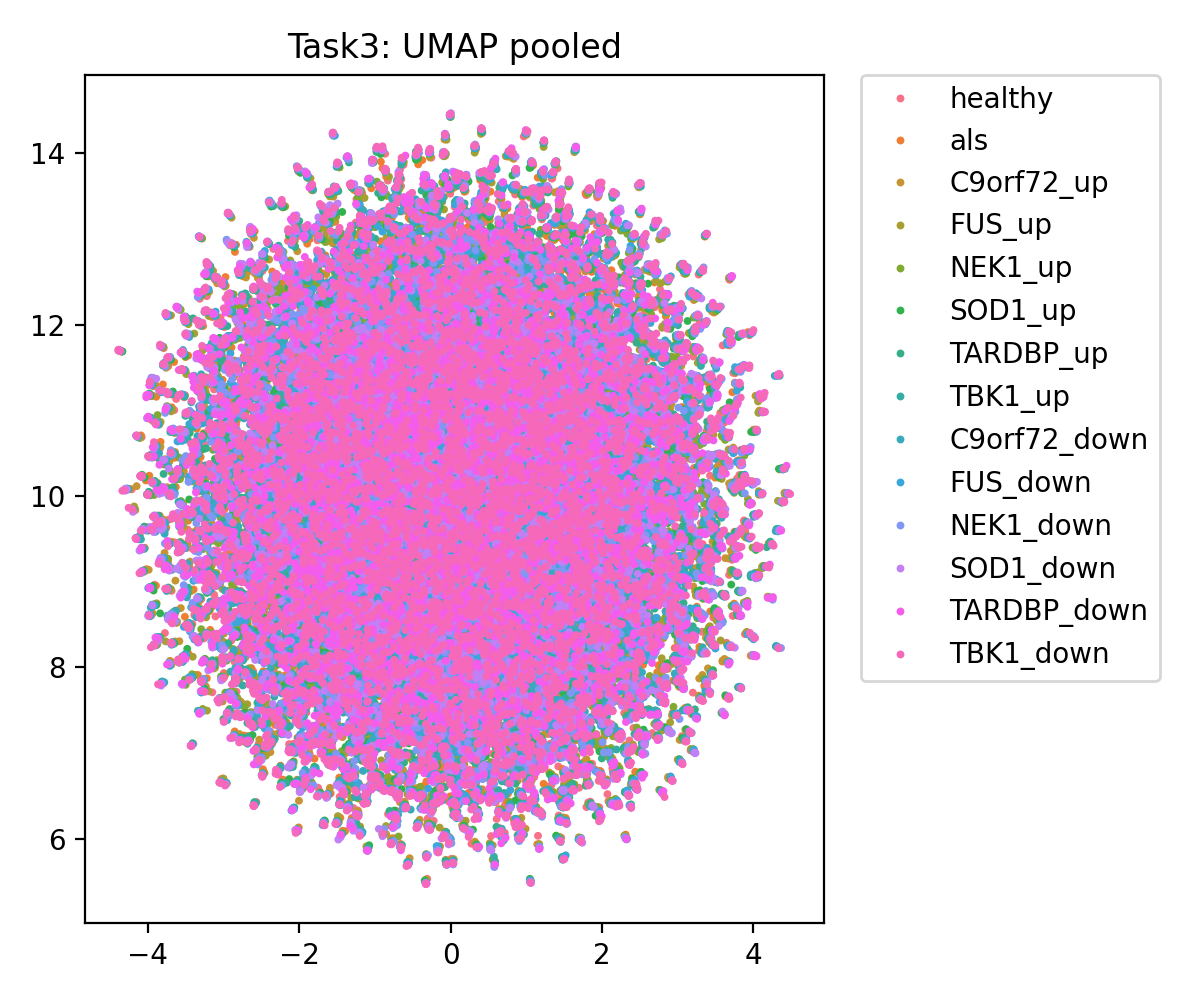

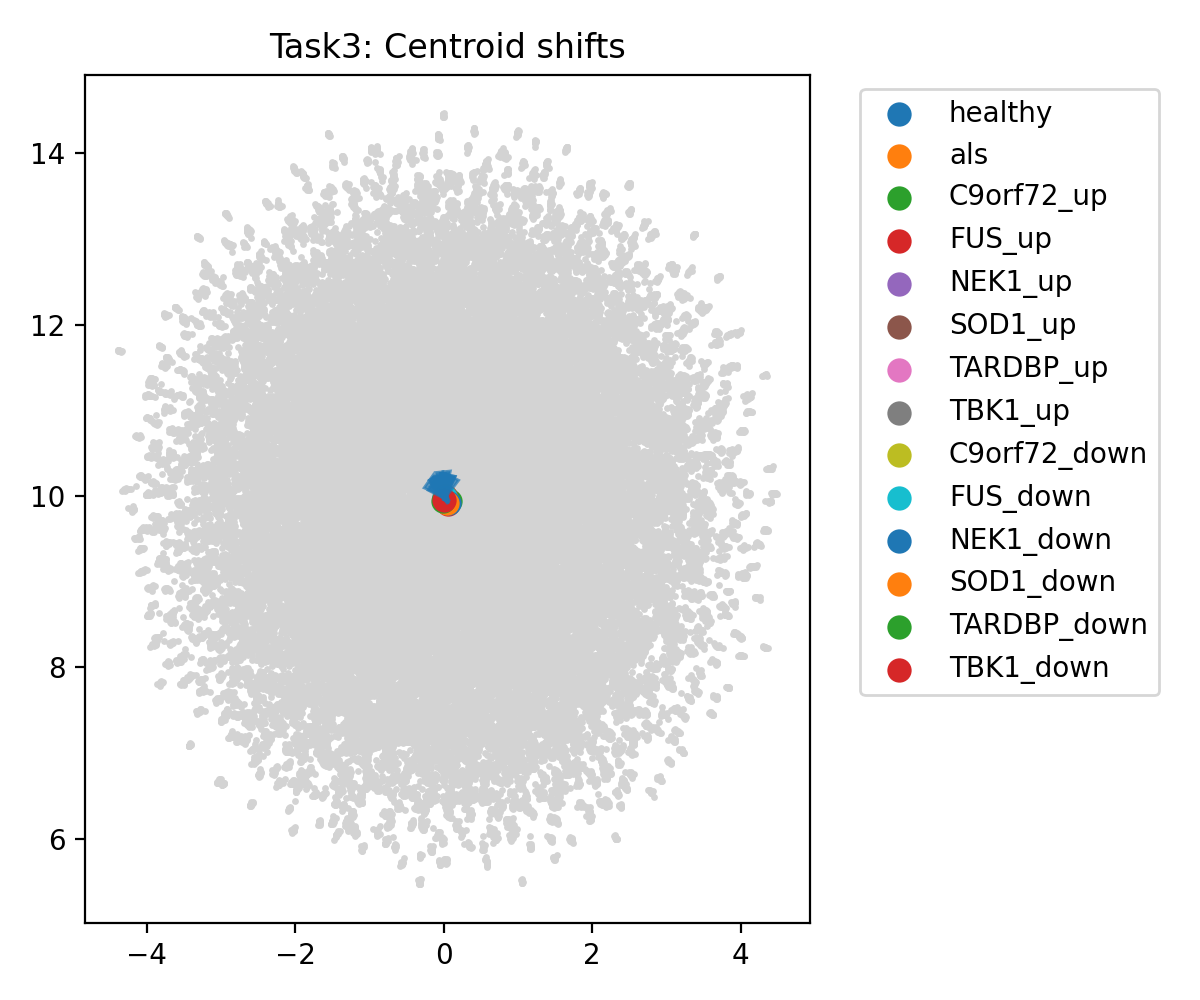


Top perturbations by delta_to_healthy:


,set,perturbation,delta_to_healthy,improvement_toward_healthy,wasserstein_before,wasserstein_after,knn_overlap_gain,silhouette_before,silhouette_after,delta_from_healthy
3,ALS_down,SOD1_down,0.006163,-0.006163,2.089197,2.096234,-0.000281,0.074633,0.075190,NaN
1,ALS_down,FUS_down,0.002112,-0.002112,2.089197,2.093796,0.000006,0.074633,0.074833,NaN
0,ALS_down,C9orf72_down,0.000250,-0.000250,2.089197,2.089185,-0.000114,0.074633,0.074665,NaN
5,ALS_down,TBK1_down,0.000145,-0.000145,2.089197,2.089008,0.000006,0.074633,0.074631,NaN
4,ALS_down,TARDBP_down,0.000131,-0.000131,2.089197,2.089579,0.000000,0.074633,0.074638,NaN
2,ALS_down,NEK1_down,-0.001514,0.001514,2.089197,2.087195,-0.000025,0.074633,0.074538,NaN
6,Healthy_up,C9orf72_up,NaN,NaN,0.000000,0.023165,-0.166015,0.000000,0.000926,0.019430
7,Healthy_up,FUS_up,NaN,NaN,0.000000,0.028514,-0.273834,0.000000,0.003212,0.036253
8,Healthy_up,NEK1_up,NaN,NaN,0.000000,0.073084,-0.361637,0.000000,0.005920,0.034421
9,Healthy_up,SOD1_up,NaN,NaN,0.000000,0.027364,-0.407177,0.000000,0.007697,0.058755


In [10]:
# Display saved figures and metrics
from IPython.display import Image, display

# Show saved UMAP plot
umap_path = FIG_DIR / 'task3_umap.png'
if umap_path.exists():
    display(Image(str(umap_path)))
else:
    print("UMAP plot not found")

# Show saved centroid shifts plot
cent_path = FIG_DIR / 'task3_centroid_shifts.png'
if cent_path.exists():
    display(Image(str(cent_path)))
else:
    print("Centroid shifts plot not found")

# Display metrics table sorted by delta_to_healthy
print("\nTop perturbations by delta_to_healthy:")
display(metrics_df.sort_values('delta_to_healthy', ascending=False))

